# PoC - RV FILE PROCESSING

**IMPORTANT NOTE:** changed locally line 499 from `gls.py` from https://github.com/mzechmeister/GLS/blob/master/python/gls.py (accessed 2023/02/18), for compatibility with Matplotlib 3.4 (as per https://github.com/raysect/source/issues/383#issue-848246478)

<<< fig.canvas.set_window_title('GLS periodogram') 

\>>> fig.canvas.manager.set_window_title('GLS periodogram')

This notebook uses the `Gls` class to calculate and manage the Lomb-Scargle periodogram for a given RV curve.<<

We will generate and store the file in a `fits` file, containing a main header and 2 _HDUs_:

- Header:
    - Object name (OBJECT = (KARMENES name))
    - Object common name (NAME = (Object common name) or None).
    - Object TIC id (TIC = (TESS identifier) or None).
    - Object right ascension, J2000 (RA_J2000 = 'RA_J2000')
    - Object declination, J2000 (DE_J2000 = 'DE_J2000')
    - Spectral type (SPTYPE = 'SpT')
    - Effective temperature in Kelvin (TEFF_K = 'Teff_K')
    - Logarithm of surface gravity (LOGG = 'logg')
    - Metallicity (FEH = '\[FeH\]'
    - Luminosity compared to Sun's (L_LSUN = 'L_Lsol')
    - Radius compared to Sun's (R_RSUN = 'R_Rsol')
    - Mass compared to Sun's (M_MSUN = 'M_Msol')
    - Distance in parsec (D_PC = 'd_pc')
- HDU 1:
  - Data - The light curve, three columns:
    - time
    - flux
    - flux_err
  - Header - Must include at least the following values:
    - Object KARMENES name (OBJECT = (KARMENES name)).
    - Time units (PUNIT = u.d).
    - Frequency units (FUNIT = 1 / u.d).
    - Number of points in the light curve (RVPOINTS = gls.N).
    - Mean of RV (AGVFLUX = gls.\_Y)
    - RMS of RV (RMSFLUX = gls.\_YY).
    - Sampling period (the median of the difference values) (PSAMPLE = (calculated value)).
    - Sampling frequency (FSAMPLE = (1.0 / PSAMPLE).
    - Nyquist frequency (FNYQUIST = 0.5 * FSAMPLE).
- HDU 2:
  - Data - The calculated periodogram of the light curve, two columns:
    - freq
    - power
  - Header - Must include at least the following values:
    - Object KARMENES name (OBJECT = (KARMENES name).
    - Frequency units (FUNIT = 1 / u.d).
    - Period units (PUNIT = u.d).
    - Peak frequency (PK_FREQ = gls.best.e\_f).
    - Peak power (PK_POWER = gls.pmax).
    - Peak SNR (PK_SNR = BEST_A / gls.rms)
    - RMS of residuals (RES_RMS = gls.rms).
    - Sampling frequency (FSAMPLE = (1.0 / PSAMPLE)).
    - Nyquist frequency (FNYQUIST = 0.5 * FSAMPLE).
    - Number of frequency points (FPOINTS = (as chosen))
    - Start frequency (FBEG = gls.fbeg).
    - End frequency (FEND = gls.fend).
    - Frequency resolution (FRES = (calculated)).
    - Best frequency (F = gls.best.f).
    - Best frequency error (E_F = gls.best.e\_f).
    - Best period (P = gls.best.P).
    - Best period error (E_P = gls.best.e\_P).
    - Best amplitude (A = gls.best.A).
    - Best amplitude error (E_A = gls.best.e\_A).
    - Best phase (PH = gls.best.ph).
    - Best phase error (E_PH = gls.best.e\_ph).
    - Best reference epoch (T0 = gls.best.T0).
    - Best reference epoch error (E_T0 = gls.best.e\_T0).
    - Best offset (OFF = gls.best.offset).
    - Best offset error (E_OFF = gls.best.e\_offset).
    - Oversampling factor (OFAC = gls.ofac).
    - Maximum frequency factor (HIFAC = gls.hifac).
    - Normalization value (FNORM = gls.norm).
    - Lomb-Scargle calculation (i.e. not GLS) (LS = gls.ls (as chosen)).
    - Fast, recursive trigonometric calculations (FAST = gsl.fast (as chosen)).


## Modules and configuration

### Modules

In [1]:
# Modules import:
from collections import OrderedDict
import pandas as pd

# https://github.com/mzechmeister/GLS
from gls import Gls

import numpy as np

from scipy import stats

from astropy.table import Table, QTable
from astropy.timeseries import TimeSeries
from astropy import units as u
from astropy.time import Time
from astropy.io import fits

import lightkurve as lk

%matplotlib inline
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 11, 11

#import seaborn as sns
#sns.set_style("white", {'figure.figsize':(15,10)})
#sns.set_style("whitegrid")
#sns.set(rc={'figure.figsize':(15,8)})

### Configuration

In [2]:
# Configuration:
DATA_FILE = "../data/GTO_objects.csv"
# Files:
RV_INPUT_FILE = "../data/CARM_VIS_RVs/J00051+457.avc.dat"

PG_OUT_FILE = "../data/CARM_VIS_RVs_PGs/ETL_25_01_Test_RV_and_PG.fits"
IMAGE_RV_OUT = "./img/ETL_25_02_Test_Graph_Radial_velocity_curve.png"


In [3]:
def rv_load(filename: str):
    '''Load the RV file and returns a lightcurve object'''
    rv_lk = Table.read(filename, format='ascii',
                    names = ['time', 'RV', 'eRV'], units=[u.d, u.meter / u.second, u.meter / u.second])
    rv_lk = lk.LightCurve(time=rv_lk['time'], flux=rv_lk['RV'], flux_err=rv_lk['eRV'])
    return rv_lk

In [4]:
def rv_infer_sampling(rv_lk: lk.LightCurve):
    '''Infer sampling period from light curve'''
    time_diffs = rv_lk['time'][1:] - rv_lk['time'][:-1]
    return np.median(time_diffs)

## Sequential testing

### Data loading

In [5]:
# Load data:
rv_lk = rv_load(RV_INPUT_FILE)
rv_lk

time,flux,flux_err
,m / s,m / s
Time,float64,float64
2457400.285149251,-7.699507225686425,1.518085090707883
2457421.2603704045,-2.206803928034396,1.7542602861873953
2457588.6812777855,3.9463531997833456,1.6999474316532919
2457605.665631484,-0.24865047388008532,1.5273324594779027
2457609.668912377,2.899844972125228,2.300501097508865
2457610.6746126967,0.1274551116349898,2.591715002116716
2457611.622353685,-0.5321407073330857,2.4855980080476785
2457620.4387825723,-5.589271196225743,2.6719922616824587


### GLS Periodogram

#### Calculation conditions

The stars currently under analysis are in the $He_{3}$ instability band, so they are expected to have effective temperatures in the range $T_{eff}\in[3300, 4300] K$, $\log g\in[4.5, 5.1]$, and masses in the range $M_{star}\in[0.20, 0.60] M_{Sun}$.

According to _Table 2_ in _The theoretical instability strip of M dwarf stars (Rodríguez-López, C., et al. 2014, MNRAS, 438, 2371)_ these stars have typical periods of $20 min$ to $3 h$, so we will set the limits of the periodogram frequencies for periods between $10 min$ and $5 h$. In days, this corresponds to a range of $P\in[0.006944, 0.208333] d$ or, equivalently, frequencies in the range $f\in[144, 4.8] d^{-1}$.

We will use the default "ZK" normalization.

#### Create instance

**Note:** we write all the parameters even if we use the default values, just to have them as a reference.

In [6]:
# Create GLS instance:
gls = Gls((rv_lk['time'].value, rv_lk['flux'].value, rv_lk['flux_err'].value),
          fbeg=4.8, fend=144, Pbeg=None, Pend=None, ofac=10, hifac=1, freq=None,
          norm="ZK", ls=False, fast=False, verbose=False)
gls

####  Check some attributes

The time series in array form:

In [7]:
gls.t

array([2457400.28514925, 2457421.2603704 , 2457588.68127779,
       2457605.66563148, 2457609.66891238, 2457610.6746127 ,
       2457611.62235369, 2457620.43878257, 2457633.58721701,
       2457636.57223794, 2457645.5905544 , 2457647.49317724,
       2457648.64650153, 2457649.609663  , 2457653.52287052,
       2457657.52945386, 2457678.41504316, 2457685.48435945,
       2457688.46666075, 2457695.40243521, 2457705.35007876,
       2457711.35138445, 2457910.58999352, 2457936.62096702,
       2457937.6165758 , 2457939.50616032, 2457946.62486882,
       2457951.48621326, 2457954.46375037, 2457956.49417135,
       2457960.61745801, 2457961.58898518, 2457962.61584783,
       2457964.59065309, 2457965.61240031, 2457968.63660116,
       2457970.6700896 , 2457971.62424086, 2457977.45829154,
       2457987.58612915, 2457997.52808947, 2458000.55007322,
       2458001.55263395, 2458002.59445461, 2458005.52505635,
       2458007.5673713 , 2458009.52179151, 2458030.46155424,
       2458058.42230376,

In [8]:
gls.y

array([-7.69950723, -2.20680393,  3.9463532 , -0.24865047,  2.89984497,
        0.12745511, -0.53214071, -5.5892712 , -0.59129012, -0.19704525,
       -6.16417413,  4.3476666 ,  3.546218  ,  0.30304323, -1.2912066 ,
       -0.38364498,  2.92447322,  6.03275881, -2.62496105,  1.7601651 ,
       -6.74152291,  5.16233776, -3.10275872,  3.19058099,  3.95722303,
       -0.57446   ,  5.28847678, -0.68896417,  0.34084262,  4.49683953,
       -1.61597259, -0.44210673, -0.78198647, -1.26252311, -0.05003086,
        3.4830356 ,  3.46357387,  1.55443989,  3.4635761 , -0.85153877,
       -1.15543609,  1.97272918,  0.46921099, -3.02339435, -2.42922359,
        0.23701784,  0.59456471, -1.2994799 , -0.37715898, -0.97551815,
       -1.16472226, -1.25224446])

In [9]:
gls.e_y

array([1.51808509, 1.75426029, 1.69994743, 1.52733246, 2.3005011 ,
       2.591715  , 2.48559801, 2.67199226, 2.81870136, 2.53750907,
       1.69897104, 1.76027105, 2.51366057, 2.18639801, 1.86075409,
       1.98058133, 2.31782575, 5.40691386, 1.46157322, 2.2045434 ,
       1.39041225, 1.77161381, 2.47371416, 1.75381942, 1.72798743,
       1.85083034, 1.7336894 , 1.90074898, 1.91203283, 2.06648852,
       1.51660274, 1.40640933, 1.34216173, 1.25188075, 1.45962721,
       1.1628978 , 1.23650884, 1.09176479, 1.67938852, 1.42362665,
       1.29625799, 1.27602068, 1.25633039, 1.36524498, 1.37909495,
       1.33591545, 1.26590126, 1.81475901, 1.71403714, 1.36529311,
       1.27332371, 1.0539131 ])

The periodogram power in array form:

In [10]:
gls.power

array([0.00302243, 0.00390817, 0.00437203, ..., 0.03423988, 0.03212901,
       0.02792323])

The periodogram frequencies (x axis) in array form:

In [11]:
gls.freq

array([  4.8       ,   4.80014426,   4.80028851, ..., 143.99966262,
       143.99980688, 143.99995113])

In [12]:
type(gls.freq)

numpy.ndarray

In [13]:
gls.freq.shape

(964958,)

#### Full information on the `GLS` object

In [14]:
gls.info(stdout=True)

Generalized LS - statistical output
-----------------------------------
Number of input points:         52
Weighted mean of dataset:   -0.050943
Weighted rms of dataset:    2.835825
Time base:                  693.216479
Number of frequency points: 964958

Maximum power p [ZK]: 0.424227
FAP(pmax):            0.12104561467930286
RMS of residuals:     2.151815
  Mean weighted internal error:  1.593912
Best sine frequency:  79.553993 +/- 0.000168
Best sine period:     0.012570 +/- 0.000000
Amplitude:            2.794887 +/- 0.422006
-----------------------------------


And with a return value (interesting to store in the results array for all GTO stars):

In [15]:
gls_info = gls.info(stdout=False)
gls_info

'Generalized LS - statistical output\n-----------------------------------\nNumber of input points:         52\nWeighted mean of dataset:   -0.050943\nWeighted rms of dataset:    2.835825\nTime base:                  693.216479\nNumber of frequency points: 964958\n\nMaximum power p [ZK]: 0.424227\nFAP(pmax):            0.12104561467930286\nRMS of residuals:     2.151815\n  Mean weighted internal error:  1.593912\nBest sine frequency:  79.553993 +/- 0.000168\nBest sine period:     0.012570 +/- 0.000000\nAmplitude:            2.794887 +/- 0.422006\n-----------------------------------'

#### Recover and calculate interesting values

It can be interesting to store some or all of the following key values in their own, separate columns in the results table for all GTO objects.

Number of points in RV curve:

In [16]:
gls.N

52

Weighted mean of RV curve:

In [17]:
gls._Y

-0.05094310699246005

Weighted rms of RV curve:

In [18]:
gls._YY

8.041901388025053

Best period in days and error:

In [19]:
gls.best['P']

0.012570079250658017

In [20]:
gls.best['e_P']

2.6481080348217134e-08

Best period in hours and error:

In [21]:
24.0 * gls.best['P']

0.30168190201579237

In [22]:
24.0 * gls.best['e_P']

6.355459283572112e-07

Best period in minutes and error:

In [23]:
24.0 * 60.0 * gls.best['P']

18.100914120947543

In [24]:
24.0 * 60.0 * gls.best['e_P']

3.813275570143267e-05

Signal amplitude and error:

In [25]:
gls.best['amp']

2.794886736597751

In [26]:
gls.best['e_amp']

0.42200571886801413

Maximum periodogram power:

In [27]:
gls.power.max()

0.42422702389948536

RMS of residuals:

In [28]:
gls.rms

2.151815395355755

#### Modified plot of the light curve

As in the case of instance creation, we put all the paremeters as a reference, even if default values are used.

c:\users\ciroe\gls.py:645: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


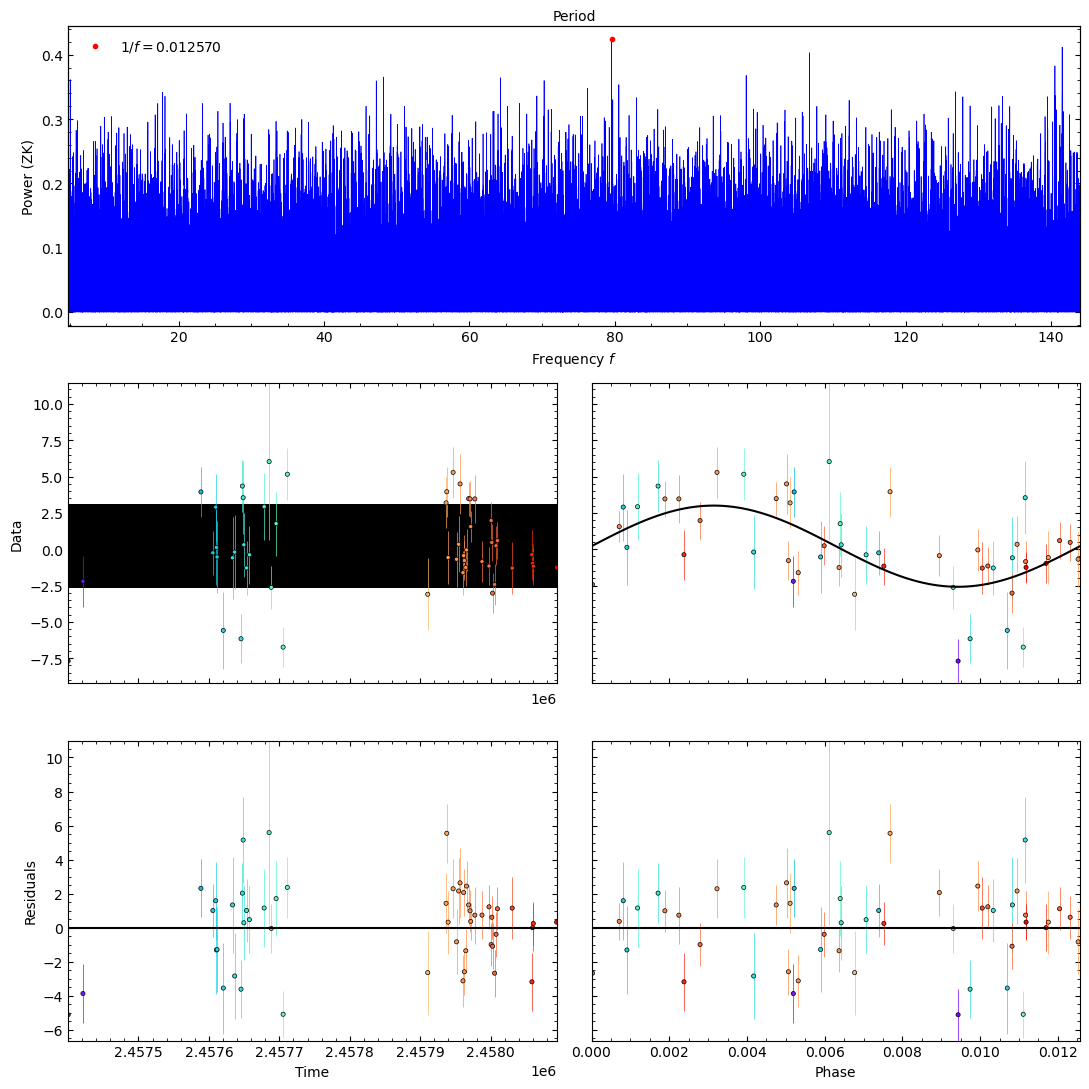

In [29]:
# Standard plot:
fig = gls.plot(block=False, period=False, fap=None, gls=True, data=True, residuals=True);

We now elaborate a slightly customized plot:

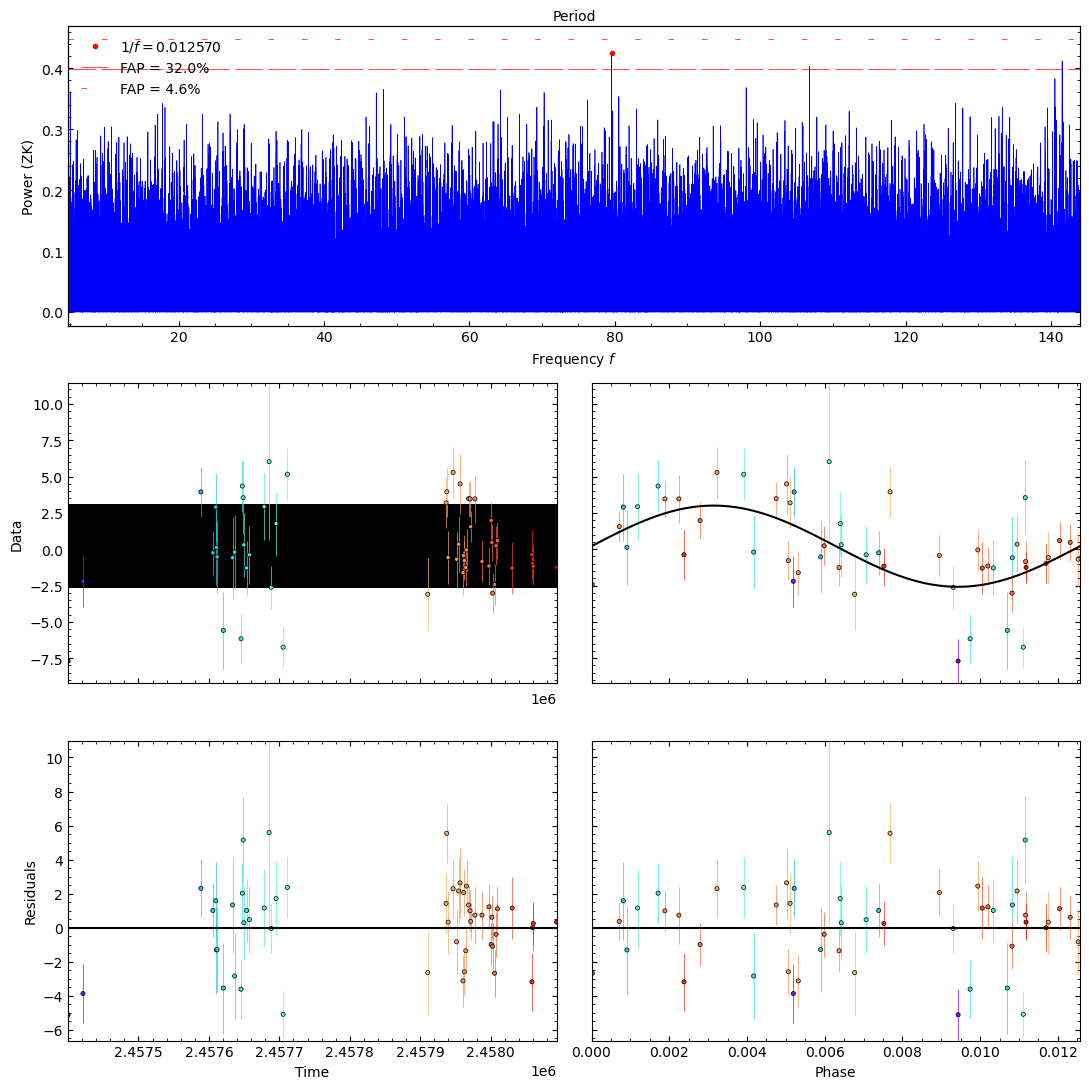

In [30]:
# Standard plot:
fig = gls.plot(block=False, period=False,
               fap=[0.3200, 0.0460], gls=True, data=True, residuals=True);

In [31]:
fig.suptitle("J00051+457")
fig.tight_layout()
fig.savefig(IMAGE_RV_OUT)

## Store the lightcurve and periodogram in 'fits' format

We will generate and store the file in a `fits` file, containing a main header and 2 _HDUs_, as described above:    

### Generate a primary `HDU` for basic header information

At the moment, the header contains just the object name:

In [32]:
primary_header = fits.Header()

In [33]:
primary_header['OBJECT'] = ("J00051+457", "KARMENES target name")
primary_header['NAME'] = ("GJ 2", "Object common name")
primary_header['TIC'] = ("439946126", "Object TESS identifier")
primary_header['RA_J2000'] = ("00:05:10.89", "Object right ascension (J2000)")
primary_header['DE_J2000'] = ("+45:47:11.6", "Object declination (J2000)")
primary_header['SPTYPE'] = ("M1.0 V", "Spectral type")
primary_header['TEFF_K'] = (3773, "Effective temperature in Kelvin")
primary_header['LOGG'] = (5.07, "Logarithm of surface gravity")
primary_header['FEH'] = (-0.04, "Metallicity")
primary_header['L_LSUN'] = (0.0436229, "Luminosity in Solar luminosities")
primary_header['R_RSUN'] = (0.48881, "Radius in Solar radii")
primary_header['M_MSUN'] = (0.4918, "Mass in Solar masses")
primary_header['D_PC'] = (11.50352803, "Distance in parsec")


In [34]:
hdu_primary = fits.PrimaryHDU(header=primary_header)

In [35]:
hdu_primary.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
OBJECT  = 'J00051+457'         / KARMENES target name                           
NAME    = 'GJ 2    '           / Object common name                             
TIC     = '439946126'          / Object TESS identifier                         
RA_J2000= '00:05:10.89'        / Object right ascension (J2000)                 
DE_J2000= '+45:47:11.6'        / Object declination (J2000)                     
SPTYPE  = 'M1.0 V  '           / Spectral type                                  
TEFF_K  =                 3773 / Effective temperature in Kelvin                
LOGG    =                 5.07 / Logarithm of surface gravity                   
FEH     =                -0.04 / Metallicity                                    
L_LSUN  =            0.04362

### Generate the `QTable` instances

Generate a `QTable` object containing the RV curve.

In [36]:
rv_lk.head()

time,flux,flux_err
,m / s,m / s
Time,float64,float64
2457400.285149251,-7.699507225686425,1.518085090707883
2457421.2603704045,-2.206803928034396,1.7542602861873953
2457588.6812777855,3.9463531997833456,1.6999474316532919
2457605.665631484,-0.24865047388008532,1.5273324594779027
2457609.668912377,2.899844972125228,2.300501097508865


In [37]:
rv_tbl = QTable(rv_lk.to_table())
rv_tbl

time,flux,flux_err
,m / s,m / s
Time,float64,float64
2457400.285149251,-7.699507225686425,1.518085090707883
2457421.2603704045,-2.206803928034396,1.7542602861873953
2457588.6812777855,3.9463531997833456,1.6999474316532919
2457605.665631484,-0.24865047388008532,1.5273324594779027
2457609.668912377,2.899844972125228,2.300501097508865
2457610.6746126967,0.1274551116349898,2.591715002116716
2457611.622353685,-0.5321407073330857,2.4855980080476785
2457620.4387825723,-5.589271196225743,2.6719922616824587


Generate a `QTable` object containing the periodogram.

In [38]:
pg_tbl = QTable(data=[gls.freq, gls.power], names=['freq', 'power'], units=[1.0 / u.d, (u.m / u.s) ** 2])
pg_tbl

freq,power
1 / d,m2 / s2
float64,float64
4.8,0.003022433798356641
4.8001442550819675,0.003908165328127241
4.800288510163935,0.004372034928360511
4.800432765245903,0.004210087321191156
4.800577020327871,0.004146853519391315
4.800721275409838,0.0052309388284144335
4.800865530491806,0.007971885393028188
4.801009785573774,0.012555012636867934


### Generate the header units

#### Radial velocity curve

In [39]:
hdu_rv = fits.table_to_hdu(rv_tbl)

In [40]:
hdu_rv.name = "RV_CURVE"

In [41]:
hdu_rv.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                   52 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TIMESYS = 'UTC     '           / Default time scale                             
JDREF   =                  0.0 / Time columns are jd = jd1 + jd2                
TREFPOS = 'TOPOCENTER'         / Time reference position                        
TTYPE1  = 'time    '                                                            
TFORM1  = '2D      '        

In [42]:
hdu_rv.data[:10]

FITS_rec([([ 2.45740000e+06,  2.85149251e-01], -7.69950723, 1.51808509),
          ([ 2.45742100e+06,  2.60370404e-01], -2.20680393, 1.75426029),
          ([ 2.45758900e+06, -3.18722215e-01],  3.9463532 , 1.69994743),
          ([ 2.45760600e+06, -3.34368516e-01], -0.24865047, 1.52733246),
          ([ 2.45761000e+06, -3.31087623e-01],  2.89984497, 2.3005011 ),
          ([ 2.45761100e+06, -3.25387303e-01],  0.12745511, 2.591715  ),
          ([ 2.45761200e+06, -3.77646315e-01], -0.53214071, 2.48559801),
          ([ 2.45762000e+06,  4.38782572e-01], -5.5892712 , 2.67199226),
          ([ 2.45763400e+06, -4.12782987e-01], -0.59129012, 2.81870136),
          ([ 2.45763700e+06, -4.27762062e-01], -0.19704525, 2.53750907)],
         dtype=(numpy.record, [('time', '<f8', (2,)), ('flux', '<f8'), ('flux_err', '<f8')]))

In [43]:
psample = rv_infer_sampling(rv_lk).value
fsample = 1.0 / psample
fnyq = 2.0 * fsample
freq_units = u.d ** (-1)

In [44]:
# Add values to header:
hdu_rv.header['OBJECT'] = ("J00051+457", "KARMENES target name")
hdu_rv.header['PUNIT'] = u.d.to_string(format='fits')
hdu_rv.header['FUNIT'] = freq_units.to_string(format='fits')
hdu_rv.header['RVPOINTS'] = (gls.N, "Number of points in the RV curve")
hdu_rv.header['AVGFLUX'] = (gls._Y, "Average flux of RV curve")
hdu_rv.header['RMSFLUX'] = (gls._YY, "Flux RMS of RV curve")
hdu_rv.header['PSAMPLE'] = (psample, "Inferred cadence in RV curve")
hdu_rv.header['FSAMPLE'] = (fsample, "Inferred sampling frequency in RV curve")
hdu_rv.header['FNYQUIST'] = (fnyq, "Calculated Nyquist frequency value")
hdu_rv.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                   52 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TIMESYS = 'UTC     '           / Default time scale                             
JDREF   =                  0.0 / Time columns are jd = jd1 + jd2                
TREFPOS = 'TOPOCENTER'         / Time reference position                        
TTYPE1  = 'time    '                                                            
TFORM1  = '2D      '        

#### Periodogram

In [45]:
hdu_pg = fits.table_to_hdu(pg_tbl)

In [46]:
hdu_pg.name = "GLS_PG"

In [47]:
hdu_pg.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =               964958 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'freq    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'd-1     '                                                            
TTYPE2  = 'power   '                                                            
TFORM2  = 'D       '        

In [48]:
hdu_pg.data[:10]

FITS_rec([(4.8       , 0.00302243), (4.80014426, 0.00390817),
          (4.80028851, 0.00437203), (4.80043277, 0.00421009),
          (4.80057702, 0.00414685), (4.80072128, 0.00523094),
          (4.80086553, 0.00797189), (4.80100979, 0.01255501),
          (4.80115404, 0.02026695), (4.8012983 , 0.03398342)],
         dtype=(numpy.record, [('freq', '<f8'), ('power', '<f8')]))

In [49]:
fpoints = len(gls.f)
fres = (gls.fend - gls.fbeg) / (fpoints - 1)

In [50]:
# Add values to header:
hdu_pg.header['OBJECT'] = ("J00051+457", "KARMENES target name")
hdu_pg.header['FUNIT'] = (freq_units.to_string(format='fits'), "Unit for frequencies")
hdu_pg.header['PUNIT'] = (u.d.to_string(format='fits'), "Unit for periods")
hdu_pg.header['PK_FREQ'] = (gls.best['f'], "Frequency of the peak in periodogram")
hdu_pg.header['PK_POW'] = (gls.pmax, "Power of the peak in periodogram")
hdu_pg.header['PK_SNR'] = (gls.pmax, "Power of the peak in periodogram")
hdu_pg.header['RES_RMS'] = (gls.rms, "RMS of residuals in periodogram")
hdu_pg.header['FSAMPLE'] = (fsample, "Inferred sampling frequency in RV curve")
hdu_pg.header['FNYQUIST'] = (fnyq, "Calculated Nyquist frequency value")
hdu_pg.header['FPOINTS'] = (fpoints, "Number of points in periodogram")
hdu_pg.header['FBEG'] = (gls.fbeg, "Start frequency in periodogram")
hdu_pg.header['FEND'] = (gls.fend, "End frequency in periodogram")
hdu_pg.header['FRES'] = (fres, "Frequency resolution in periodogram")
hdu_pg.header['F'] = (gls.best['f'], "Peak best estimate: frequency")
hdu_pg.header['E_F'] = (gls.best['e_f'], "Peak best estimate: frequency error")
hdu_pg.header['P'] = (gls.best['P'], "Peak best estimate: period")
hdu_pg.header['E_P'] = (gls.best['e_P'], "Peak best estimate: period error")
hdu_pg.header['A'] = (gls.best['amp'], "Peak best estimate: amplitude")
hdu_pg.header['E_A'] = (gls.best['e_amp'], "Peak best estimate: amplitude error")
hdu_pg.header['PH'] = (gls.best['ph'], "Peak best estimate: phase")
hdu_pg.header['E_PH'] = (gls.best['e_ph'], "Peak best estimate: phase error")
hdu_pg.header['T0'] = (gls.best['T0'], "Peak best estimate: frequency")
hdu_pg.header['E_T0'] = (gls.best['e_T0'], "Peak best estimate: frequency error")
hdu_pg.header['OFF'] = (gls.best['offset'], "Peak best estimate: offset")
hdu_pg.header['E_OFF'] = (gls.best['e_offset'], "Peak best estimate: offset error")
hdu_pg.header['OFAC'] = (gls.ofac, "Setup: oversampling factor")
hdu_pg.header['HIFAC'] = (gls.ofac, "Setup: maximum frequency factor")
hdu_pg.header['NORM'] = (gls.norm, "Setup: normalization type")
hdu_pg.header['LS'] = (gls.ls, "Setup: conventional Lomb-Scargle calculation")
hdu_pg.header['FAST'] = (gls.ofac, "Setup: fast evaluation, recursive trigonometric")
hdu_pg.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =               964958 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'freq    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'd-1     '                                                            
TTYPE2  = 'power   '                                                            
TFORM2  = 'D       '        

### Create the fits object with the header and the two `HDU`

In [51]:
hdul = fits.HDUList([hdu_primary, hdu_rv, hdu_pg])

In [52]:
hdul

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002B3062E7970>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000002B34BD2EF10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000002B305607D30>]

### Write the `fits` object to file

In [53]:
hdul.close()

In [54]:
hdul.writeto(PG_OUT_FILE, overwrite=True)

**NOTE:** it is important to close the `HDUList` object after use, as well as also delete the read data, so as to eliminate all the pointers to the file (see https://docs.astropy.org/en/stable/io/fits/index.html#working-with-large-files).

In [55]:
hdul.close()

In [56]:
del hdul

In [57]:
del hdu_primary

In [58]:
del hdu_rv

In [59]:
del hdu_pg

### Test opening recently created `fits`file and working with it

In [60]:
read_hdul = fits.open(PG_OUT_FILE, mode='update', memmap=False)
read_hdul

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002B305612CD0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000002B3056124F0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000002B305612970>]

In [61]:
read_hdul.info()

Filename: ./img/ETL_25_01_Test_RV_and_PG.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1  RV_CURVE      1 BinTableHDU     33   52R x 3C   [2D, D, D]   
  2  GLS_PG        1 BinTableHDU     45   964958R x 2C   [D, D]   


#### Retrieve basic information

In [62]:
read_hdul['PRIMARY'].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
OBJECT  = 'J00051+457'         / KARMENES target name                           
NAME    = 'GJ 2    '           / Object common name                             
TIC     = '439946126'          / Object TESS identifier                         
RA_J2000= '00:05:10.89'        / Object right ascension (J2000)                 
DE_J2000= '+45:47:11.6'        / Object declination (J2000)                     
SPTYPE  = 'M1.0 V  '           / Spectral type                                  
TEFF_K  =                 3773 / Effective temperature in Kelvin                
LOGG    =                 5.07 / Logarithm of surface gravity                   
FEH     =                -0.

In [63]:
read_hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
OBJECT  = 'J00051+457'         / KARMENES target name                           
NAME    = 'GJ 2    '           / Object common name                             
TIC     = '439946126'          / Object TESS identifier                         
RA_J2000= '00:05:10.89'        / Object right ascension (J2000)                 
DE_J2000= '+45:47:11.6'        / Object declination (J2000)                     
SPTYPE  = 'M1.0 V  '           / Spectral type                                  
TEFF_K  =                 3773 / Effective temperature in Kelvin                
LOGG    =                 5.07 / Logarithm of surface gravity                   
FEH     =                -0.

#### Retrieve RV curve information

In [64]:
read_hdul['RV_CURVE']

In [65]:
read_hdul['RV_CURVE'].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                   52 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TIMESYS = 'UTC     '           / Default time scale                             
JDREF   =                  0.0 / Time columns are jd = jd1 + jd2                
TREFPOS = 'TOPOCENTER'         / Time reference position                        
TTYPE1  = 'time    '                                                            
TFORM1  = '2D      '        

In [66]:
read_hdul['RV_CURVE'].data[:10]

FITS_rec([([ 2.45740000e+06,  2.85149251e-01], -7.69950723, 1.51808509),
          ([ 2.45742100e+06,  2.60370404e-01], -2.20680393, 1.75426029),
          ([ 2.45758900e+06, -3.18722215e-01],  3.9463532 , 1.69994743),
          ([ 2.45760600e+06, -3.34368516e-01], -0.24865047, 1.52733246),
          ([ 2.45761000e+06, -3.31087623e-01],  2.89984497, 2.3005011 ),
          ([ 2.45761100e+06, -3.25387303e-01],  0.12745511, 2.591715  ),
          ([ 2.45761200e+06, -3.77646315e-01], -0.53214071, 2.48559801),
          ([ 2.45762000e+06,  4.38782572e-01], -5.5892712 , 2.67199226),
          ([ 2.45763400e+06, -4.12782987e-01], -0.59129012, 2.81870136),
          ([ 2.45763700e+06, -4.27762062e-01], -0.19704525, 2.53750907)],
         dtype=(numpy.record, [('time', '>f8', (2,)), ('flux', '>f8'), ('flux_err', '>f8')]))

In [67]:
read_rv_table = QTable.read(read_hdul['RV_CURVE'])
read_rv_table

time,flux,flux_err
d,m / s,m / s
float64[2],float64,float64
2457400.0 .. 0.28514925111085176,-7.699507225686425,1.518085090707883
2457421.0 .. 0.2603704044595361,-2.206803928034396,1.7542602861873953
2457589.0 .. -0.3187222145497799,3.9463531997833456,1.6999474316532919
2457606.0 .. -0.3343685162253678,-0.24865047388008532,1.5273324594779027
2457610.0 .. -0.3310876227915287,2.899844972125228,2.300501097508865
2457611.0 .. -0.3253873032517731,0.1274551116349898,2.591715002116716
2457612.0 .. -0.3776463149115443,-0.5321407073330857,2.4855980080476785
2457620.0 .. 0.43878257228061557,-5.589271196225743,2.6719922616824587


#### Retrieve periodogram information

In [68]:
read_hdul['GLS_PG']

In [69]:
read_hdul['GLS_PG'].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =               964958 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'freq    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'd-1     '                                                            
TTYPE2  = 'power   '                                                            
TFORM2  = 'D       '        

In [70]:
read_hdul['GLS_PG'].data[:10]

FITS_rec([(4.8       , 0.00302243), (4.80014426, 0.00390817),
          (4.80028851, 0.00437203), (4.80043277, 0.00421009),
          (4.80057702, 0.00414685), (4.80072128, 0.00523094),
          (4.80086553, 0.00797189), (4.80100979, 0.01255501),
          (4.80115404, 0.02026695), (4.8012983 , 0.03398342)],
         dtype=(numpy.record, [('freq', '>f8'), ('power', '>f8')]))

In [71]:
read_pg_table = QTable.read(read_hdul['GLS_PG'])
read_pg_table

freq,power
1 / d,m2 / s2
float64,float64
4.8,0.003022433798356641
4.8001442550819675,0.003908165328127241
4.800288510163935,0.004372034928360511
4.800432765245903,0.004210087321191156
4.800577020327871,0.004146853519391315
4.800721275409838,0.0052309388284144335
4.800865530491806,0.007971885393028188
4.801009785573774,0.012555012636867934


**NOTE:** it is important to close the `HDUList` object after use, as well as also delete the read data, so as to eliminate all the pointers to the file (see https://docs.astropy.org/en/stable/io/fits/index.html#working-with-large-files).

Reading the file with the option `memmap=False` prevents this problem form happening, even if you don't clear all the possible pointers to the file, but this could be not an option for large files, i.e. those which can not be fully loaded into memory.

In [72]:
read_hdul.close()

In [73]:
del read_hdul

## Summary

**OBSERVATIONS AND CONCLUSIONS:**
- We have tested the GLS class.
- We have stored all the information about an object (RV curve, periodogram, and basic results) in a `fits` file. **NOTE:** `fits`file was finally dropped in favour of storing just the periodogram data in plain text, with a ".dat" extension (`fits` generation was left as an option, though).
- Now we should be ready to apply this process to all CARMENES objects in a batch processing.